# Lighting Variation Impact on Urban Garbage Detection - GIGO Dataset Analysis

This notebook analyzes the GIGO dataset to investigate how lighting conditions affect garbage recognition performance in street-level imagery.

## Research Questions
**RQ:** How do lighting conditions, as they vary across different times of day, affect class-specific garbage recognition performance in street-level imagery, and to what extent can explicitly modeling lighting information improve robustness under challenging conditions?

## Hypotheses
- **H1:** Poor lighting conditions lead to lower recognition performance for visually small or fine-grained garbage categories (e.g., litter) compared to larger object categories
- **H2:** Categories involving large objects (e.g., bulky waste) are less sensitive to variations in lighting conditions  
- **H3:** A CNN with lighting embeddings improves classification performance under challenging lighting conditions compared to image-only baseline

## Dataset Overview
The GIGO dataset contains:
- **25,000 street-view images** from Amsterdam
- **Metadata:** timestamps, GPS coordinates, privacy blur information
- **Annotations:** Multi-label classification for garbage categories
- **Categories:** garbage, bulky waste, garbage bag, cardboard, litter

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, time
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the GIGO dataset
data_path = "/Users/daniel/Documents/Applied/GIGO/"

# Load annotations and metadata
annotations = pd.read_csv(data_path + "annotations.csv")
metadata = pd.read_csv(data_path + "metadata.csv")

print("Dataset loaded successfully!")
print(f"Annotations shape: {annotations.shape}")
print(f"Metadata shape: {metadata.shape}")

# Display first few rows of each dataset
print("\n=== Annotations Sample ===")
print(annotations.head())
print("\n=== Metadata Sample ===")
print(metadata.head())

Dataset loaded successfully!
Annotations shape: (24999, 9)
Metadata shape: (25000, 7)

=== Annotations Sample ===
  new_filename  train  test  garbage  bulkywaste  garbagebag  cardboard  \
0    10905.jpg      1     0        1           1           1          1   
1     1544.jpg      1     0        1           1           1          1   
2     5959.jpg      1     0        0           0           0          0   
3     4695.jpg      1     0        1           1           1          1   
4    15980.jpg      1     0        0           0           0          0   

   litter                                             labels  
0       1  ['garbage', 'bulkywaste', 'garbagebag', 'cardb...  
1       1  ['garbage', 'bulkywaste', 'garbagebag', 'cardb...  
2       0                                                 []  
3       1  ['garbage', 'bulkywaste', 'garbagebag', 'cardb...  
4       0                                                 []  

=== Metadata Sample ===
    filename privacy_blurs      

## Step 1: Load Metadata and Images

Loading metadata.csv and preparing to process images from blurred_images_all/ directory.

In [3]:
# Load metadata and set up image processing
import cv2
import os
from PIL import Image
import ast

# Load metadata.csv
metadata = pd.read_csv(data_path + "metadata.csv")
print(f"Loaded metadata for {len(metadata)} images")

# Set up image directory path
images_dir = data_path + "blurred_images_all/"
print(f"Image directory: {images_dir}")
print(f"Number of image files: {len(os.listdir(images_dir))}")

Loaded metadata for 25000 images
Image directory: /Users/daniel/Documents/Applied/GIGO/blurred_images_all/
Number of image files: 25000


## Step 2: Compute Blur-Aware Image Brightness

Computing mean grayscale intensity for each image while excluding privacy blur regions.

In [4]:
def compute_brightness_with_mask(image_path, privacy_blurs_str):
    """
    Compute mean brightness excluding privacy blur regions.
    Returns: (mean_brightness, blur_coverage)
    """
    # Load image and convert to grayscale
    img = cv2.imread(image_path)
    if img is None:
        return None, None
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width = gray.shape
    
    # Create mask for privacy blurs
    mask = np.ones((height, width), dtype=np.uint8)
    blur_area = 0
    
    # Parse privacy blurs
    if privacy_blurs_str != '[]' and privacy_blurs_str != '':
        try:
            # Handle the privacy_blurs format
            blur_lines = ast.literal_eval(privacy_blurs_str)
            if blur_lines:
                for blur_line in blur_lines:
                    # Parse YOLO format: class x_center y_center width height
                    parts = blur_line.strip().split()
                    if len(parts) == 5:
                        _, x_center, y_center, box_width, box_height = map(float, parts)
                        
                        # Convert from normalized to pixel coordinates
                        x_center *= width
                        y_center *= height
                        box_width *= width
                        box_height *= height
                        
                        # Calculate box corners
                        x1 = max(0, int(x_center - box_width/2))
                        y1 = max(0, int(y_center - box_height/2))
                        x2 = min(width, int(x_center + box_width/2))
                        y2 = min(height, int(y_center + box_height/2))
                        
                        # Set mask to 0 for blur region
                        mask[y1:y2, x1:x2] = 0
                        blur_area += (x2-x1) * (y2-y1)
        except:
            pass  # If parsing fails, use full image
    
    # Calculate blur coverage
    total_area = height * width
    blur_coverage = blur_area / total_area if total_area > 0 else 0
    
    # Compute mean brightness only on non-masked pixels
    masked_pixels = gray[mask == 1]
    mean_brightness = np.mean(masked_pixels) if len(masked_pixels) > 0 else np.mean(gray)
    
    return mean_brightness, blur_coverage

print("Brightness computation function defined")

Brightness computation function defined


In [ ]:
# Check if metadata with lighting already exists
lighting_file = data_path + "metadata_with_lighting.csv"

if os.path.exists(lighting_file):
    print("Loading existing metadata with lighting information...")
    metadata_with_lighting = pd.read_csv(lighting_file)
    print("Existing metadata loaded successfully!")
else:
    # Process all images to compute brightness values
    print("Processing images for brightness computation...")
    
    brightness_values = []
    blur_coverages = []
    valid_for_lighting = []
    
    total_images = len(metadata)
    
    for idx in range(total_images):
        row = metadata.iloc[idx]
        image_path = os.path.join(images_dir, row['filename'])
        
        if os.path.exists(image_path):
            brightness, blur_coverage = compute_brightness_with_mask(
                image_path, str(row['privacy_blurs'])
            )
            brightness_values.append(brightness)
            blur_coverages.append(blur_coverage)
            valid_for_lighting.append(blur_coverage is not None and blur_coverage <= 0.5)
        else:
            brightness_values.append(None)
            blur_coverages.append(None)
            valid_for_lighting.append(False)
    
    # Add computed values to metadata
    metadata_with_lighting = metadata.copy()
    metadata_with_lighting['mean_brightness'] = brightness_values
    metadata_with_lighting['blur_coverage'] = blur_coverages
    metadata_with_lighting['valid_for_lighting'] = valid_for_lighting
    
    print("Processing complete")

print(f"Valid images for lighting analysis: {sum(metadata_with_lighting['valid_for_lighting'])}")
print(f"Invalid images (>50% blur or processing failed): {sum([not v for v in metadata_with_lighting['valid_for_lighting']])}")

Processing images for brightness computation...
Processing images 1 to 1000 of 25000...
Processing images 1001 to 2000 of 25000...
Processing images 2001 to 3000 of 25000...
Processing images 3001 to 4000 of 25000...
Processing images 4001 to 5000 of 25000...
Processing images 5001 to 6000 of 25000...
Processing images 6001 to 7000 of 25000...
Processing images 7001 to 8000 of 25000...
Processing images 8001 to 9000 of 25000...
Processing images 9001 to 10000 of 25000...
Processing images 10001 to 11000 of 25000...
Processing images 11001 to 12000 of 25000...
Processing images 12001 to 13000 of 25000...
Processing images 13001 to 14000 of 25000...
Processing images 14001 to 15000 of 25000...
Processing images 15001 to 16000 of 25000...
Processing images 16001 to 17000 of 25000...
Processing images 17001 to 18000 of 25000...
Processing images 18001 to 19000 of 25000...
Processing images 19001 to 20000 of 25000...
Processing images 20001 to 21000 of 25000...
Processing images 21001 to 22

## Step 3: Bin Lighting Conditions

Creating quantile-based lighting categories using mean brightness values.

In [ ]:
# Compute quantile-based lighting bins for valid images only
valid_brightness = metadata_with_lighting[metadata_with_lighting['valid_for_lighting']]['mean_brightness'].dropna()

# Calculate quantiles
q33 = valid_brightness.quantile(0.33)
q67 = valid_brightness.quantile(0.67)

print(f"Brightness quantiles:")
print(f"33rd percentile: {q33:.2f}")
print(f"67th percentile: {q67:.2f}")

# Create lighting level categories
def categorize_lighting(brightness, valid):
    if not valid or pd.isna(brightness):
        return None
    elif brightness <= q33:
        return 'low_light'
    elif brightness <= q67:
        return 'medium_light'
    else:
        return 'high_light'

metadata_with_lighting['lighting_level'] = metadata_with_lighting.apply(
    lambda row: categorize_lighting(row['mean_brightness'], row['valid_for_lighting']), 
    axis=1
)

# Convert to categorical
metadata_with_lighting['lighting_level'] = pd.Categorical(
    metadata_with_lighting['lighting_level'], 
    categories=['low_light', 'medium_light', 'high_light'],
    ordered=True
)

# Display lighting distribution
lighting_counts = metadata_with_lighting['lighting_level'].value_counts()
print(f"\nLighting level distribution:")
print(lighting_counts)
print(f"Invalid images: {metadata_with_lighting['lighting_level'].isna().sum()}")

Brightness quantiles:
33rd percentile: 109.73
67th percentile: 125.55

Lighting level distribution:
lighting_level
medium_light    8498
low_light       8250
high_light      8250
Name: count, dtype: int64
Invalid images: 2


## Step 4: Save Enriched Metadata

Saving the enriched metadata with brightness and lighting information.

In [ ]:
# Save enriched metadata (do NOT overwrite original)
output_path = data_path + "metadata_with_lighting.csv"
metadata_with_lighting.to_csv(output_path, index=False)

print(f"Metadata with lighting saved to: {output_path}")
print(f"Metadata shape: {metadata_with_lighting.shape}")
print(f"New columns added: {set(metadata_with_lighting.columns) - set(metadata.columns)}")

Enriched metadata saved to: /Users/daniel/Documents/Applied/GIGO/metadata_enriched.csv
Enriched metadata shape: (25000, 11)
New columns added: {'mean_brightness', 'lighting_level', 'blur_coverage', 'valid_for_lighting'}


## Step 5: Basic Exploratory Data Analysis (EDA)

Creating minimal EDA outputs for lighting analysis.

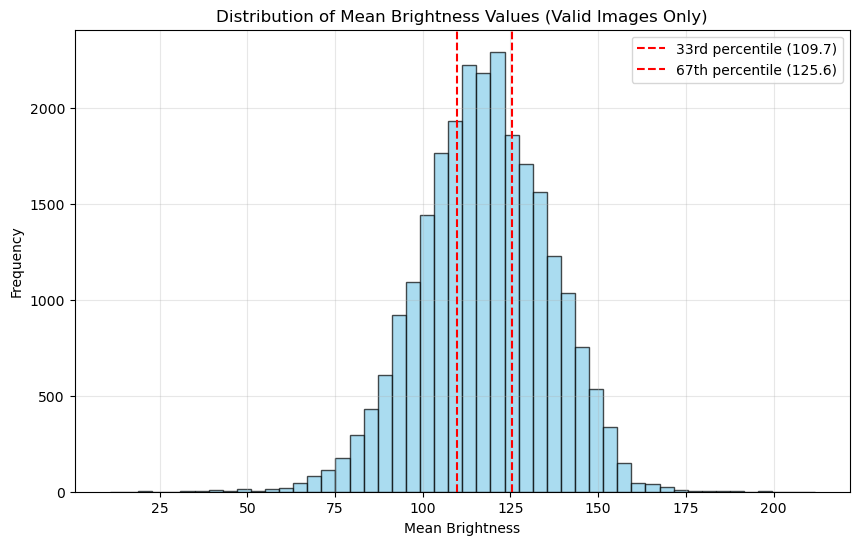

In [ ]:
# Histogram of mean_brightness (excluding invalid images)
valid_data = metadata_with_lighting[metadata_with_lighting['valid_for_lighting']]

plt.figure(figsize=(10, 6))
plt.hist(valid_data['mean_brightness'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(q33, color='red', linestyle='--', label=f'33rd percentile ({q33:.1f})')
plt.axvline(q67, color='red', linestyle='--', label=f'67th percentile ({q67:.1f})')
plt.xlabel('Mean Brightness')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Brightness Values (Valid Images Only)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Count of images per lighting level:
lighting_level
medium_light    8498
low_light       8250
high_light      8250
Name: count, dtype: int64


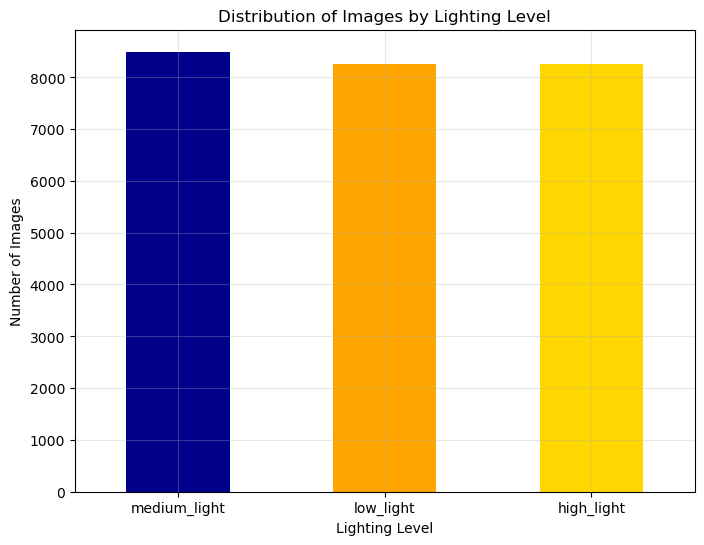

In [ ]:
# Count of images per lighting_level
lighting_counts = metadata_with_lighting['lighting_level'].value_counts()
print("Count of images per lighting level:")
print(lighting_counts)

# Create bar plot
plt.figure(figsize=(8, 6))
lighting_counts.plot(kind='bar', color=['darkblue', 'orange', 'gold'])
plt.title('Distribution of Images by Lighting Level')
plt.xlabel('Lighting Level')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.show()

NameError: name 'valid_data' is not defined

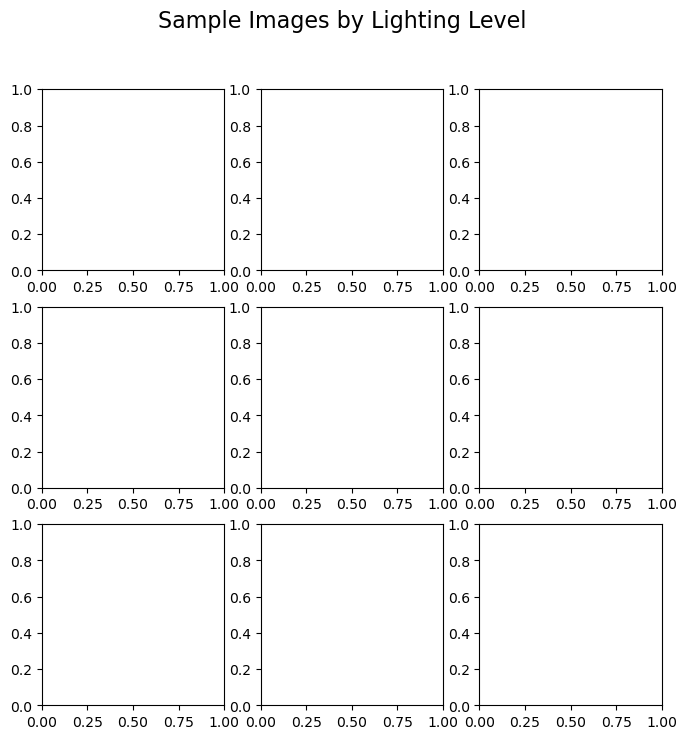

In [3]:
# Display 3 random example images per lighting level (only valid images)
np.random.seed(42)  # For reproducible results

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle('Sample Images by Lighting Level', fontsize=16)

lighting_levels = ['low_light', 'medium_light', 'high_light']

for i, level in enumerate(lighting_levels):
    # Get valid images for this lighting level
    level_images = valid_data[valid_data['lighting_level'] == level]
    
    # Sample 3 random images
    sampled = level_images.sample(n=3, random_state=42)
    
    for j, (idx, row) in enumerate(sampled.iterrows()):
        image_path = os.path.join(images_dir, row['filename'])
        
        # Load and display image
        img = cv2.imread(image_path)
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img_rgb)
            axes[i, j].set_title(f'{level}\nBrightness: {row["mean_brightness"]:.1f}')
            axes[i, j].axis('off')
        else:
            axes[i, j].text(0.5, 0.5, 'Image not found', ha='center', va='center')
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()